In [288]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings

In [289]:
warnings.filterwarnings('ignore') 
algo = 'sift'
feat_match = 'bf'

In [305]:
camera = cv2.VideoCapture(0)
ret, photo_1 =camera.read()
camera.release()
# OpenCV defines the color channel in the order BGR, converting to RGB for Matplotlib
photo_1 = cv2.cvtColor(photo_1, cv2.COLOR_BGR2RGB)
# Converting to grayscale
photo_gray_1 = cv2.cvtColor(photo_1, cv2.COLOR_RGB2GRAY)

In [306]:
# Capture an image from the mobile phone's camera and save it as the query photo
camera_2 = cv2.VideoCapture(0)  # Assuming the mobile camera is accessible via index 1
ret, photo_2 =camera_2.read()
camera_2.release()
# OpenCV defines the color channel in the order BGR, converting to RGB for Matplotlib
photo_2 = cv2.cvtColor(photo_2, cv2.COLOR_BGR2RGB)
# Converting to grayscale
photo_gray_2 = cv2.cvtColor(photo_2, cv2.COLOR_RGB2GRAY)

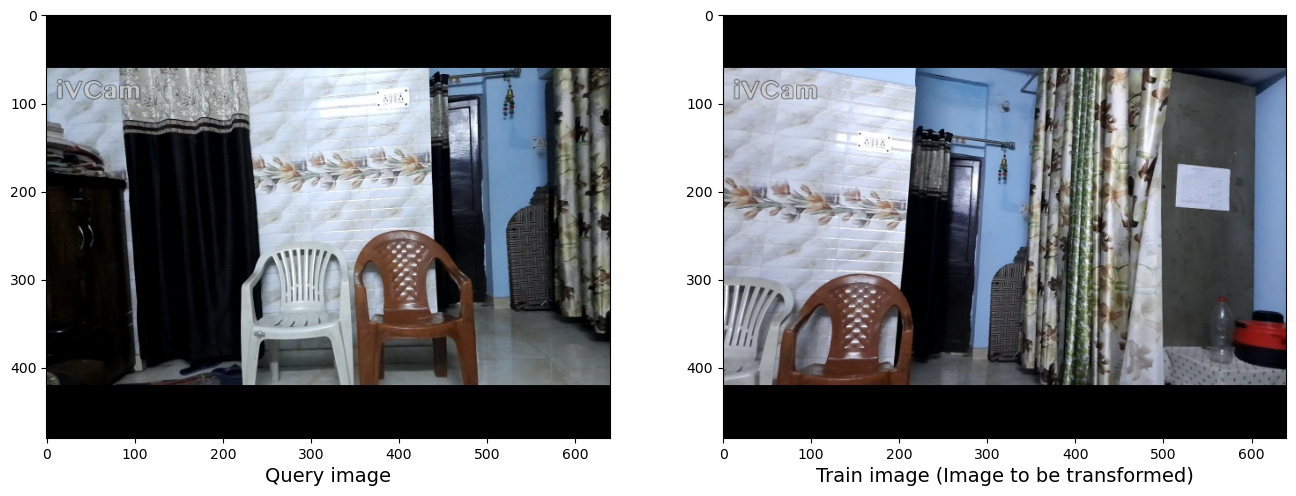

In [307]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(photo_2, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)
ax2.imshow(photo_1, cmap="gray")
ax2.set_xlabel("Tran image (Image to be transformed)", fontsize=14)
plt.savefig("./_.jpeg", bbox_inches='tight', dpi=300, format='jpeg')
plt.show()

In [308]:
def descriptor_method(image, method):    
    descriptor = cv2.SIFT_create()   
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    return (keypoints, features)

In [309]:
keypoints_1, features_img1 = descriptor_method(photo_gray_1, method=algo)
keypoints_2, features_img2 = descriptor_method(photo_gray_2, method=algo)

636.6006469726562 68.38552856445312
1.9350031614303589
86.45053100585938
0.014868013560771942
5374463
-1


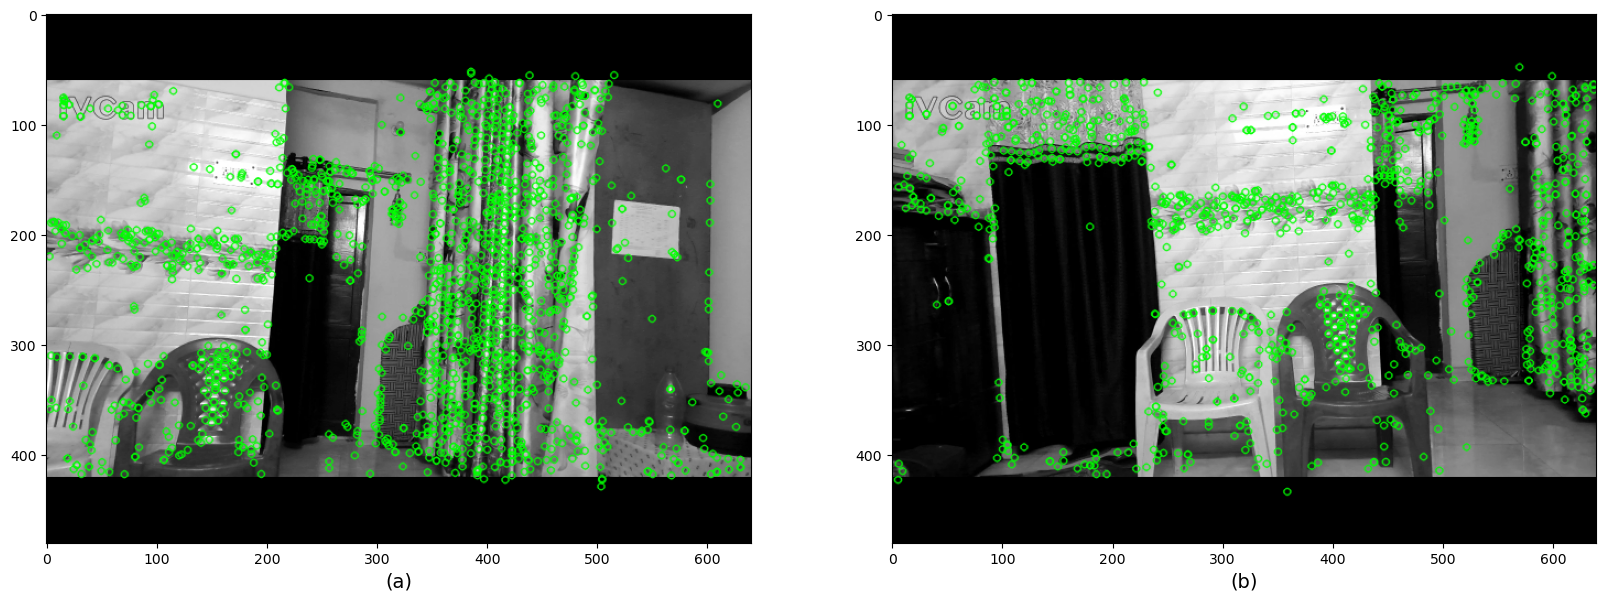

In [310]:
for keypoint in keypoints_2:
    x, y = keypoint.pt
    size = keypoint.size 
    orientation = keypoint.angle
    response = keypoint.response 
    octave = keypoint.octave
    class_id = keypoint.class_id

print (x,y)
print(size)
print(orientation)
print(response)
print(octave)
print(class_id)

# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(photo_gray_1, keypoints_1, None, color=(0,255,0)))

ax1.set_xlabel("(a)", fontsize=14)

ax2.imshow(cv2.drawKeypoints(photo_gray_2,keypoints_2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)
plt.show()

In [311]:
def matching_object(method,crossCheck):
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
        return bf

In [312]:
def keypoints_matching(features_img_1, features_img_2, method):
    bf = matching_object(method, crossCheck=True)
    best_matches = bf.match(features_img_1,features_img_2)
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches with Brute force):", len(rawMatches))
    return rawMatches

In [313]:
def keypoints_matching_KNN(features_img_1,features_img_2 , ratio, method):
    bf = matching_object(method, crossCheck=False)
    rawMatches = bf.knnMatch(features_img_1, features_img_2, k=2)
    print("Raw matches using (knn):", len(rawMatches))
    matches = []
    # loop over the raw matches
    for m,n in rawMatches:
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Drawing: knn matched features Lines
Raw matches (knn): 1561


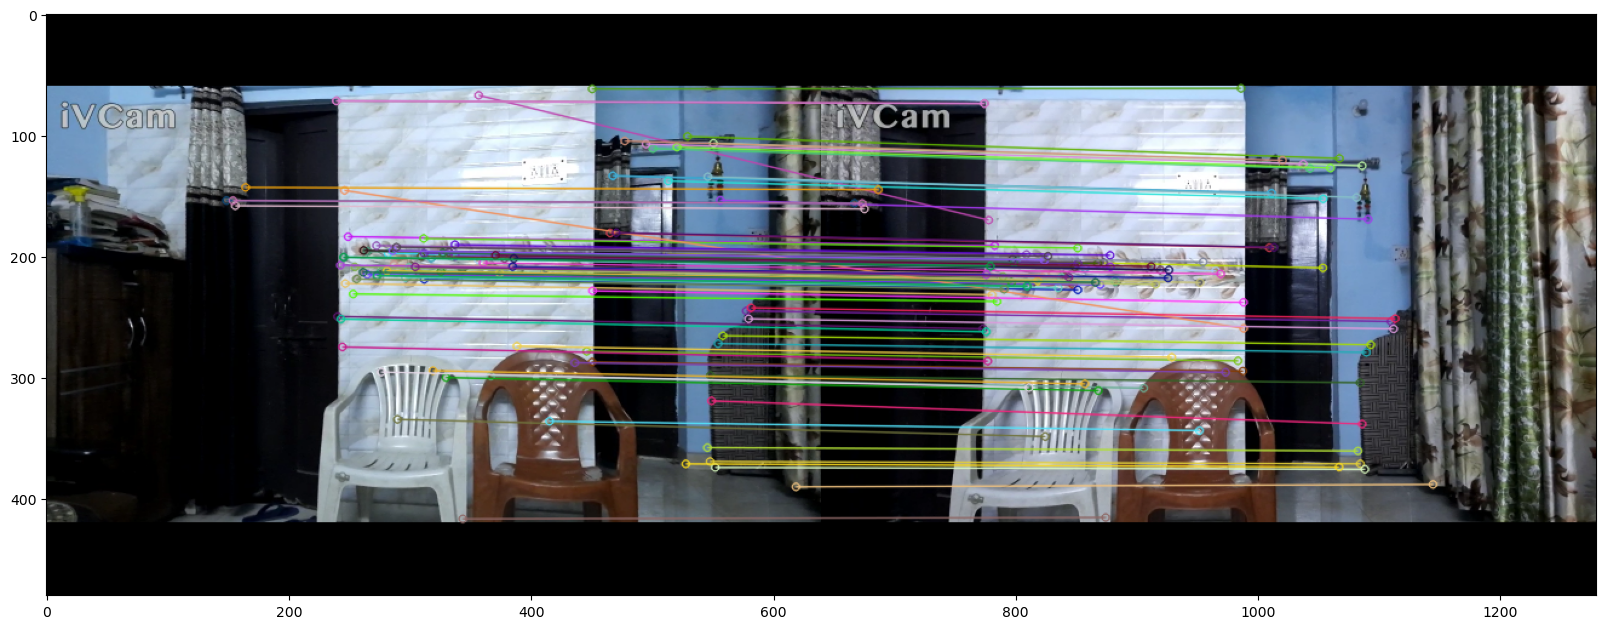

In [314]:
print("Drawing: {} matched features Lines".format(feat_match))

fig = plt.figure(figsize=(20, 8))

if feat_match == 'bf': 
    matches = keypoints_matching(features_img1, features_img2, method=algo)

    mapped_features_image = cv2.drawMatches(photo_1, keypoints_1, photo_2, keypoints_2, matches[:100],
                                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Now for cross-checking, draw the feature-mapping lines also with KNN
elif feat_match == 'knn':
    matches = keypoints_matching_KNN(features_img1, features_img2, ratio=0.75, method=algo)

    mapped_features_image_knn = cv2.drawMatches(photo_1, keypoints_1, photo_2, keypoints_2, np.random.choice(matches, 100),
                                               None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_features_image)


Drawing: knn matched features Lines
Raw matches (knn): 1561


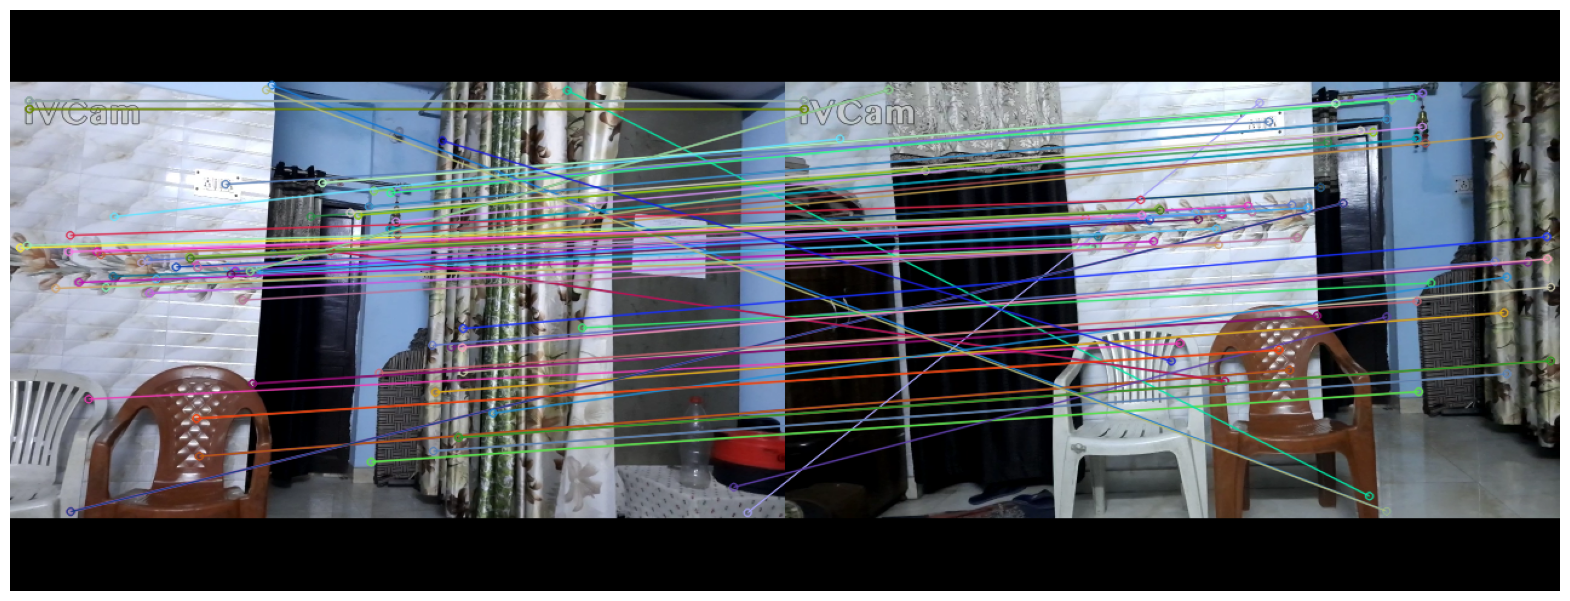

In [315]:
feature_to_match = 'knn'

print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20, 8))
feature_to_match == 'knn'
matches = keypoints_matching_KNN(features_img1, features_img2, ratio=0.75, method=algo)  # Updated variable names
mapped_features_image_using_knn = cv2.drawMatches(photo_1, keypoints_1, photo_2, keypoints_2, np.random.choice(matches, 100),
                                               None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_features_image_using_knn)
plt.axis('off')
plt.savefig("./output/" + feature_to_match + "_matching_img.jpg", bbox_inches='tight', dpi=300, format='jpeg')
plt.show()


In [316]:
def homography_stitching_Matrix(keypoints_1, keypoints_2, matches, reprojThresh):   
    keypoints_1 = np.float32([keypoint.pt for keypoint in keypoints_1])
    keypoints_2 = np.float32([keypoint.pt for keypoint in keypoints_2])
    if len(matches) > 4:
        # construct the two sets of points
        points_1 = np.float32([keypoints_1[m.queryIdx] for m in matches])
        points_2 = np.float32([keypoints_2[m.trainIdx] for m in matches])
        # Calculate the homography between the sets of points
        (H, status) = cv2.findHomography(points_1, points_2, cv2.RANSAC, reprojThresh)
        return (matches, H, status)
    else:
        return None

In [317]:
val = homography_stitching_Matrix(keypoints_1, keypoints_2, matches, reprojThresh=4)#Threshold value 4
if val is None:
    print("Error!")

(matches, Homography_Matrix, status) = val

print(Homography_Matrix)

[[ 6.19961254e-01  2.02672696e-01  1.49796375e+02]
 [-2.99970147e-01  8.51293050e-01  1.81568089e+01]
 [-9.63859461e-04  2.00331987e-04  1.00000000e+00]]


In [318]:
width = photo_2.shape[1] + photo_1.shape[1] #width of output
print("width ", width) 
height = max(photo_2.shape[0],photo_1.shape[0]) #height of output

width  1280


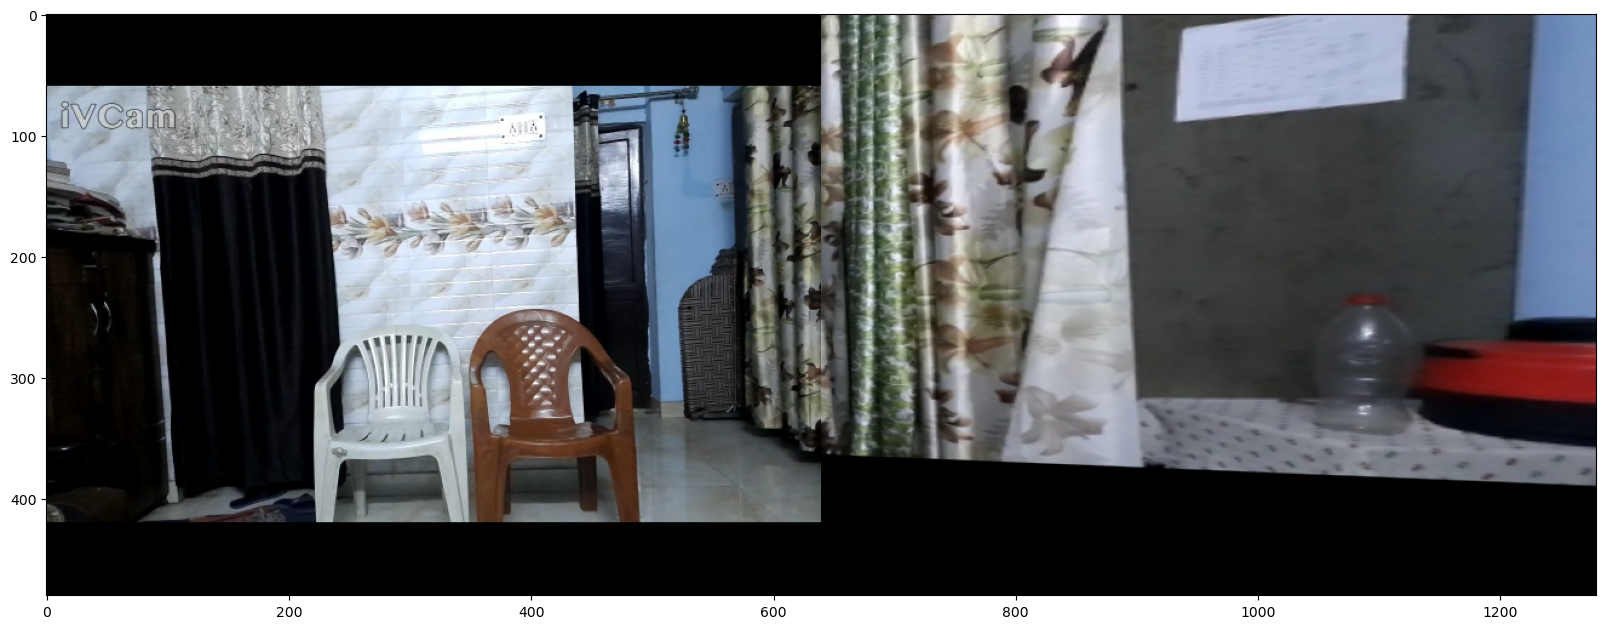

In [319]:
result = cv2.warpPerspective(photo_1, Homography_Matrix,  (width, height))
result[0:photo_2.shape[0], 0:photo_1.shape[1]] = photo_2
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()